# 02. Ice motion maps from OSI-SAF sea ice motion data
Data source: https://unep-viewer.mercator-ocean.eu/product/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/files?path=SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001%2FMETNO-GLO-SEAICE_DRIFT-NORTH-L4-NRT-OBS%2F&subdataset=osisaf_obs-si_glo_phy-sitype_nrt_sh-P1D_202107

Code by MacKenzie Jewell, edited by Noel Wang. Version in the FORK

## Import packages

In [14]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift, grab_ice_Drift


%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

#math
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### NSDIC Weekly ice motion

In [4]:
main_path = '/Volumes/Seagate2/NSIDC/'

ds = xr.open_dataset(main_path + 'icemotion_weekly_nh_25km_20230101_20240630_ql.nc')
ds.close

NSIDC = {}

NSIDC['time'] = ds.time.values
NSIDC['x'] = ds.x.values
NSIDC['y'] = ds.y.values
NSIDC['u'] = ds.u.values
NSIDC['v'] = ds.v.values
NSIDC['proj'] = grab_projinfo_PPdrift(ds)

#========
week = 52
#========

print(NSIDC['time'][week])

2024-01-01 00:00:00


In [30]:
ds
ds['xc'].shape

(119,)

### OSI-SAF sea ice drift

In [90]:

# specify date to import
#============================
date = datetime(2024, 1, 14)
#============================

#takes the middle day (peep documentation)

OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')

## Make map

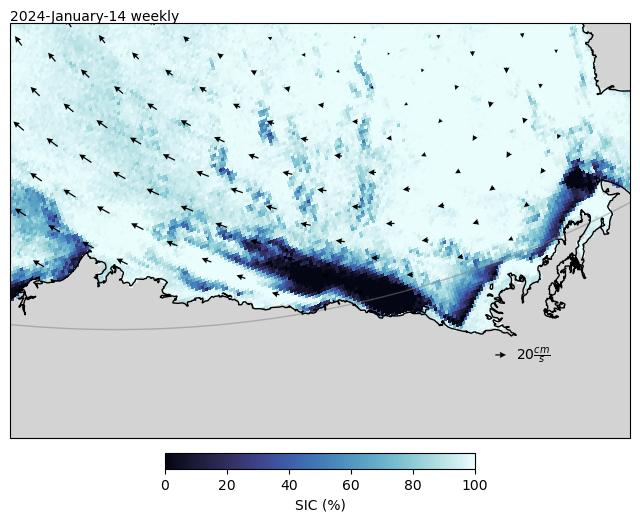

In [9]:

# specify date to plot
#============================
date = datetime(2024, 1, 14)
#============================

# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
            main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
            coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
            hemisphere='n', resolution='6250', version='v5.4', 
            return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
            include_units=False, annual_folders=False, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.025)


# label date
ax.text(0, 1, f'{date.strftime('%Y-%B-%d')} weekly', ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# OSISAF sea ice drift
# qv1 = ax.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
#                color = 'gray', width = 0.002, headwidth=5, scale = 500, transform = OSISAF['proj'], zorder=5)
# qk = ax.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


# NSIDC sea ice drift. Relabel if using.
sp = 3
qv2 = ax.quiver(NSIDC['x'][::sp], NSIDC['y'][::sp], NSIDC['u'][week,:,:][::sp,::sp], NSIDC['v'][week,:,:][::sp,::sp], 
               color = 'k', width = 0.002, headwidth=5, scale = 1000*1.15741, transform = NSIDC['proj'], zorder=5)
qk = ax.quiverkey(qv2, 0.8, 0.2, 20, r'$20 \frac{cm}{s}$', labelpos='E',transform=ccrs.PlateCarree(),)


plt.show()


## save figure, if desired
# save_path = f'/Users/jewell/Desktop/weekly_map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

## Create timeseries

In [17]:

# all_speeds = np.array([])
list_speed_of_mean_vector = []
list_mean_speed_of_vector = []
w_list_speed_of_mean_vector = []
w_list_mean_speed_of_vector = []
angles_list = []
all_dates = pd.date_range(start='2024-1-1', end='2024-1-30', freq='D')

x_cr = (22, 33) # bottom, top
y_cr = (83, 92) #left, right

for date in all_dates:

    OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')
    NSIDC = grab_ice_Drift(date = date, 
                          PPD_drift_path = '/Volumes/Seagate2/NSIDC/', PPD_filename = 'icemotion_weekly_nh_25km_20230101_20240630_ql.nc')
    
    #cropping OSI SAF data
    crop_dx = OSISAF['dx'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    crop_dy = OSISAF['dy'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    speed_of_mean_vector = np.sqrt(np.nanmean(crop_dx)**2 + np.nanmean(crop_dy)**2)
    mean_speed_of_vector = np.nanmean(np.sqrt((crop_dx)**2 + (crop_dy)**2))
    list_speed_of_mean_vector.append(speed_of_mean_vector)
    list_mean_speed_of_vector.append(mean_speed_of_vector)
    
    #angle
    angle = math.atan((np.nanmean(crop_dx))/np.nanmean(crop_dy)
             )
    angles_list.append(math.degrees(angle))
    
    #cropping NSIDC data
    crop_dx = NSIDC['dx'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    crop_dy = NSIDC['dy'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    w_speed_of_mean_vector = np.sqrt(np.nanmean(crop_dx)**2 + np.nanmean(crop_dy)**2)
    w_mean_speed_of_vector = np.nanmean(np.sqrt((crop_dx)**2 + (crop_dy)**2))
    w_list_speed_of_mean_vector.append(speed_of_mean_vector)
    w_list_mean_speed_of_vector.append(mean_speed_of_vector)


AttributeError: 'Dataset' object has no attribute 'icemotion_error_estimate'

** use geometry to find the average direction :)

In [97]:
x_grid, y_grid = np.meshgrid(OSISAF['x'], OSISAF['y'])

x_grid.shape
OSISAF["dx"].shape

(177, 119)

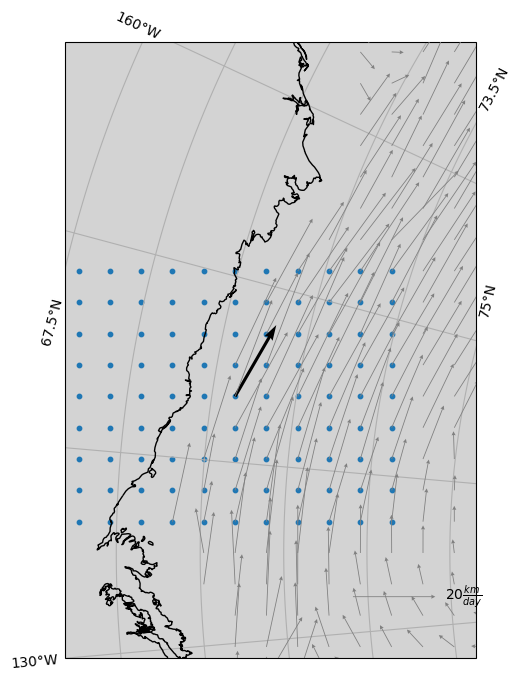

In [122]:
OSISAF.keys()
# fig2, ax2 = plt.subplots(figsize = (10, 10))

# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig2, ax2 = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=OSISAF['proj']))

# background color
ax2.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax2.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree()) 

ax2.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

ax2.scatter(x_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], y_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], transform = OSISAF['proj'], s=10)

# add coastlines
ax2.coastlines(zorder=100)


# OSISAF sea ice drift
qv1 = ax2.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
               color = 'gray', width = 0.002, headwidth=5, scale = 100, transform = OSISAF['proj'], zorder=5)
qk = ax2.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


#figure out the angle ~60°
qv2 = ax2.quiver(np.mean(x_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]), np.mean(y_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]), 0.5, math.sqrt(3)/2, scale = 5, transform = OSISAF['proj'])

In [106]:
OSISAF['proj']
print(all_speeds)
print(region_speed)
print(sum(angles_list) / len(angles_list))

[3.964068881900377, 10.017836468934972, 17.007922640257533, 17.442791066508146, 14.788787855235192, 16.441213163645568, 22.054414293696347, 25.84085828409362, 23.42145355454936, 16.47053291755631, 16.340744256034487, 21.77979481701811, 20.459691296918663, 18.80518379874745, 21.77204190303863, 8.525337878947044, 6.527147521944085, 8.541911899681942, 15.207789697463758, 15.04743614969866, 10.118182774716715, 0.9058341333580733, 5.462325431804443, 11.192953869446, 8.636827121778516, 6.46189801448419, 0.8500817191408944, 4.937820253301571, 14.205648702465927, 21.340356810064275]
21.340356810064275
0.6514323119837175


Text(0.5, 1.0, 'Sea ice drift mean speed of vectors 01-Jan-2024 to 30-Jan-2024 over polynya')

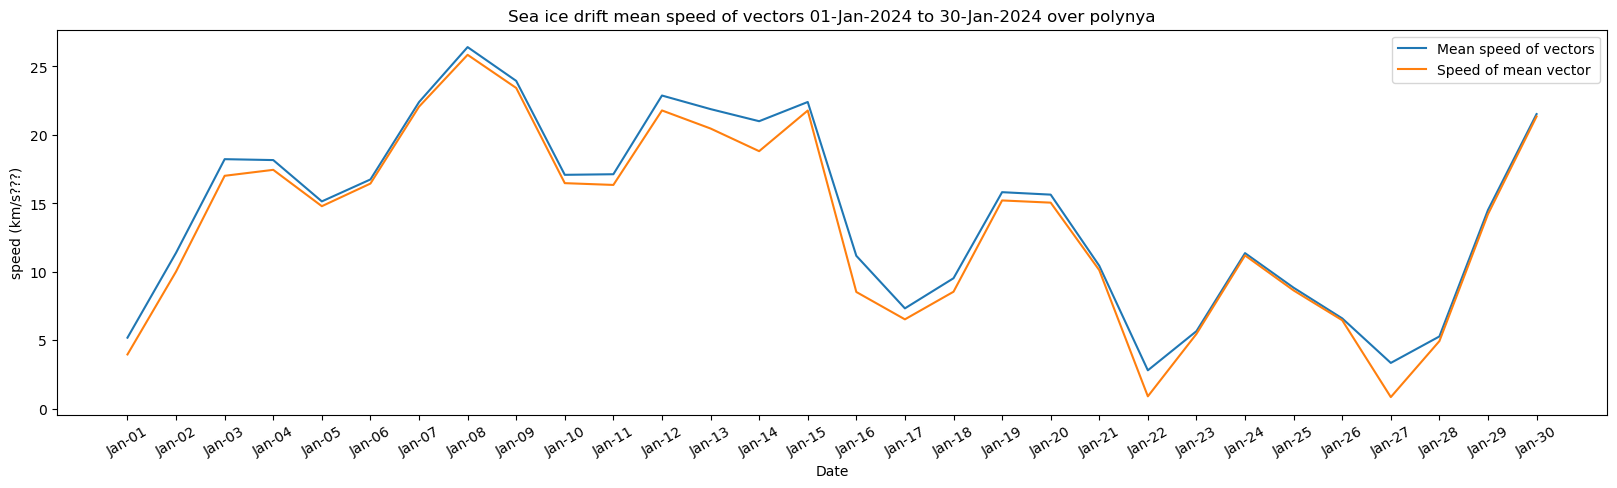

In [142]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(all_dates, list_mean_speed_of_vector, label = "Mean speed of vectors")
ax.plot(all_dates, list_speed_of_mean_vector, label = "Speed of mean vector")


#legend
ax.legend()

#ax.axhline(10, c='k', linestyle='dashed')

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(all_dates)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#labels
plt.xlabel('Date')
# ax.set_ylabel('sea ice speed (km/day)')

ax.set_ylabel('speed (km/s???)')

plt.title(f'Sea ice drift mean speed of vectors {all_dates[0].strftime("%d-%b-%Y")} to {all_dates[-1].strftime("%d-%b-%Y")} over polynya')

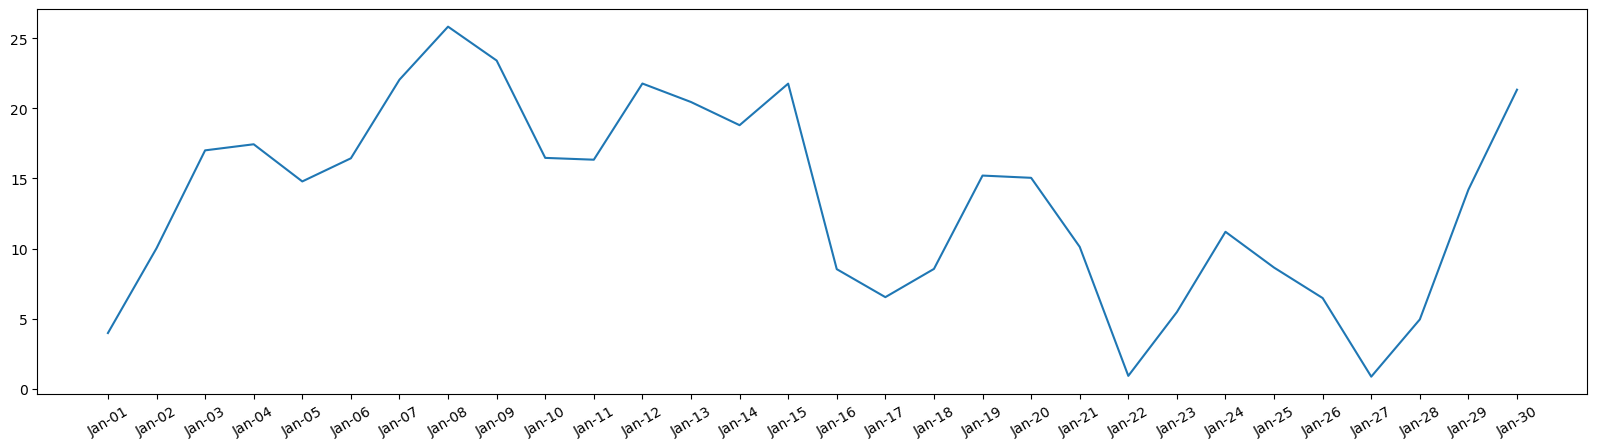

In [165]:


d = {'time': all_dates, 'speed_of_mean': list_speed_of_mean_vector, 'mean_of_speed': list_mean_speed_of_vector}
df = pd.DataFrame(data=d)
df.to_csv('./Data/speeds_ice.csv', index=None) #removes Index column
df = pd.read_csv('./Data/speeds_ice.csv')
df['time'] = pd.to_datetime(df.time)

fig3, ax3 = plt.subplots(figsize=(20,5))

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(all_dates)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.plot(df.time, df.speed_of_mean)


In [169]:
newList = ['apple', 'orange', 'peach']
newList.pop(-1)
print(newList)

['apple', 'orange']


In [135]:
pd.to_datetime(df.time)

0    2024-01-01
1    2024-01-02
2    2024-01-03
3    2024-01-04
4    2024-01-05
5    2024-01-06
6    2024-01-07
7    2024-01-08
8    2024-01-09
9    2024-01-10
10   2024-01-11
11   2024-01-12
12   2024-01-13
13   2024-01-14
14   2024-01-15
15   2024-01-16
16   2024-01-17
17   2024-01-18
18   2024-01-19
19   2024-01-20
20   2024-01-21
21   2024-01-22
22   2024-01-23
23   2024-01-24
24   2024-01-25
25   2024-01-26
26   2024-01-27
27   2024-01-28
28   2024-01-29
29   2024-01-30
Name: time, dtype: datetime64[ns]

### Creating graphs of arrows